# **Import lib**

In [19]:
from keras import models
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Reshape, Permute
from keras.optimizers import Adam

import os, shutil, random, time, numpy as np, matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

import json

import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# **Split file**

In [5]:
# Đường dẫn 
image_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/images"
annotation_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations"

output_base = "/kaggle/working/BTXRD_data"
train_dir = os.path.join(output_base, "train")
test_dir = os.path.join(output_base, "test")
valid_dir = os.path.join(output_base, "valid")

In [6]:
# Tạo thư mục lưu ảnh mới
for folder in [train_dir, test_dir, valid_dir]:
    os.makedirs(os.path.join(folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(folder, "Annotations"), exist_ok=True)

# Lấy danh sách ảnh
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
random.shuffle(image_files)

# Tính số lượng ảnh cho mỗi tập
total = len(image_files)
train_split = int(0.7 * total)
test_split = int(0.2 * total)

# Chia danh sách ảnh
train_files = image_files[:train_split]
test_files = image_files[train_split:train_split + test_split]
valid_files = image_files[train_split + test_split:]

# Hàm di chuyển ảnh và annotation tương ứng
def move_files(files, dest_folder):
    for file in files:
        # Di chuyển ảnh
        shutil.copy(os.path.join(image_dir, file), os.path.join(dest_folder, "images", file))

        # Di chuyển file annotation nếu có
        annotation_file = file.replace(file.split('.')[-1], 'json')  # Đổi đuôi thành .json
        if os.path.exists(os.path.join(annotation_dir, annotation_file)):
            shutil.copy(os.path.join(annotation_dir, annotation_file), os.path.join(dest_folder, "Annotations", annotation_file))

# Di chuyển các tập dữ liệu
move_files(train_files, train_dir)
move_files(test_files, test_dir)
move_files(valid_files, valid_dir)

print(f"Đã chia {total} ảnh thành:")
print(f"- Train: {len(train_files)} ảnh")
print(f"- Test: {len(test_files)} ảnh")
print(f"- Valid: {len(valid_files)} ảnh")


Đã chia 3746 ảnh thành:
- Train: 2622 ảnh
- Test: 749 ảnh
- Valid: 375 ảnh


# **SegNet**

In [15]:
n_classes = 2     # normal, tumor
img_h = img_w = 96

In [13]:
# Đường dẫn 
data_dir = '/kaggle/input/btxrd-v2/'

train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
valid_dir = os.path.join(data_dir, "valid")

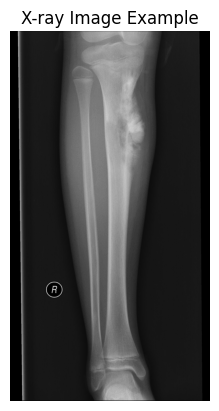

In [14]:
# đọc 1 ảnh

img_path = os.path.join(train_dir, "/Annotations/IMG000001.json")

# Đọc hình ảnh bằng OpenCV
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Hiển thị hình ảnh bằng Matplotlib
plt.imshow(image, cmap='gray')
plt.title('X-ray Image Example')
plt.axis('off')
plt.show()

Tiền xử lý dữ liệu

In [54]:
train_images_dir = os.path.join(data_dir, "train", "images")
train_annotations_dir = os.path.join(data_dir, "train", "annotations")

In [57]:
def load_data(images_dir, annotations_dir):
    images = []
    labels = []
    
    # Lấy danh sách các ảnh trong thư mục images
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    for img_file in image_files:
        img_path = os.path.join(images_dir, img_file)
        annotation_path = os.path.join(annotations_dir, os.path.splitext(img_file)[0] + '.json')

        # Đọc ảnh grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_h, img_w))
        
        # Xác định nhãn dựa vào sự tồn tại của tệp JSON
        label = 1 if os.path.exists(annotation_path) else 0
        
        images.append(img)
        labels.append(label)
    
    # Chuyển danh sách thành numpy array và chuẩn hóa
    images = np.array(images, dtype=np.float32) / 255.0  # Chuẩn hóa ảnh về khoảng [0,1]
    images = np.expand_dims(images, axis=-1)  # Thêm chiều kênh (grayscale)
    labels = to_categorical(labels, num_classes=n_classes)  # Chuyển nhãn về dạng one-hot
    
    return images, labels


In [58]:
x_train, y_train = load_data(train_images_dir, train_annotations_dir)

Xây dựng mô hình CNN

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

# Định nghĩa kiến trúc CNN
input_image = Input(shape=(img_h, img_w, 1), name='Input')

x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_image)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(128, (3, 3), padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

output_label = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=input_image, outputs=output_label, name='btxrd_cnn')

# In mô hình
model.summary()


Model: "btxrd_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 96, 96, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 94, 94, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 47, 47, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 47, 47, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 45, 45, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      31,719,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,979,970 (121.99 MB)

 Trainable params: 31,979,970 (121.99 MB)

 Non-trainable params: 0 (0.00 B)

Huấn luyện mô hình

In [21]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Train model
batch_size = 16
epochs = 30

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_valid, y_valid),
    epochs=epochs
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step - accuracy: 0.9016 - loss: 0.5043 - val_accuracy: 1.0000 - val_loss: 0.2059
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.1133 - val_accuracy: 1.0000 - val_loss: 0.0224
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 1.9028e-04 - val_accuracy: 1.0000 - val_loss: 1.0228e-04
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 4.3697e-05 - val_accuracy: 1.0000 - val_loss: 7.8678e-06
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 1.6776e-06 - val_accuracy: 1.0000 - val_loss: 7.1526e-07
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 7.8728e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 1.9301e-08 - val_accuracy: 1.

thử nah

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pandas as pd
import os

# Định nghĩa đường dẫn
train_dir = "/kaggle/input/btxrd-v2/train/images"
annotation_path = "/kaggle/input/btxrd-v2/train/Annotations/labels.csv"

# Load nhãn từ file CSV nếu có
df = pd.read_csv(annotation_path)
df['filename'] = df['filename'].astype(str)  # Chuyển về kiểu chuỗi
df['label'] = df['label'].astype(str)  # Đảm bảo nhãn là dạng string

# Thiết lập ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% cho validation
)

# Load dữ liệu từ thư mục ảnh, tự động lấy nhãn
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_dir,
    x_col="filename",
    y_col="label",
    target_size=(96, 96),
    batch_size=16,
    class_mode="categorical",
    subset="training"
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_dir,
    x_col="filename",
    y_col="label",
    target_size=(96, 96),
    batch_size=16,
    class_mode="categorical",
    subset="validation"
)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/btxrd-v2/train/Annotations/labels.csv'

Đánh giá mô hình

In [ ]:
# Đánh giá trên tập test
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

# Hiển thị lịch sử training
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Dự đoán trên ảnh mới

In [ ]:
# Dự đoán trên một ảnh X-ray
def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_h, img_w)) / 255.0
    img = np.expand_dims(img, axis=[0, -1])  # Thêm batch và channel

    pred = model.predict(img)
    class_pred = np.argmax(pred)
    label = "Normal" if class_pred == 0 else "Tumor"

    plt.imshow(img.reshape(img_h, img_w), cmap='gray')
    plt.title(f'Predicted: {label}')
    plt.axis('off')
    plt.show()

# Thử nghiệm với một ảnh trong tập test
test_image_path = os.path.join(test_dir, 'tumor', 'sample.png')
predict_image(test_image_path)
